In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_groq import ChatGroq
## from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma
import os
from langchain_ollama import OllamaEmbeddings, ChatOllama


# 1. Load your 10 PDFs
pdf_folder = "../my_pdfs"
all_docs = []
for file in os.listdir(pdf_folder):
    if file.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(pdf_folder, file))
        all_docs.extend(loader.load())

all_docs_length = len(all_docs)
print(f"==> Loaded {all_docs_length} documents from PDFs...")

In [ ]:
# 2. Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=25)
chunks = splitter.split_documents(all_docs)
chunks_length = len(chunks)
print(f"Split into {chunks_length} chunks.")

## Vector store

Creating vectorstore

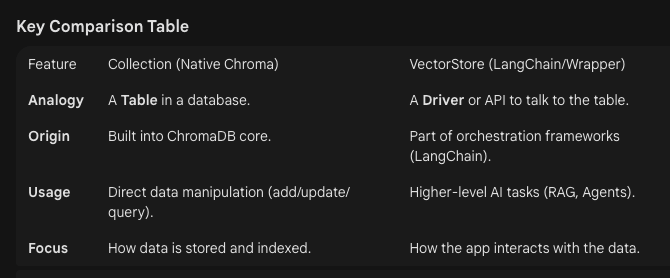

In [ ]:
# 3. Create Vector Store
# embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")
vectorstore = Chroma.from_documents(chunks, embeddings, persist_directory="../chroma_db")
retriever = vectorstore.as_retriever()


In [ ]:
retriever.invoke("what is the sales of hobbieskart?")

In [ ]:
retriever.invoke("tell me which request header to set for safeguarding CORS issue")

In [ ]:
queestion = "tell me which request header to set for safeguarding CORS issue."
docs = vectorstore.similarity_search(queestion, k=1) # K = number of results to return
# Print results
for doc in docs:
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}\n---")


In [ ]:
results = vectorstore.similarity_search_with_score(queestion, k=2)

for doc, score in results:
    print(f"Score: {score}")
    print(f"Content: {doc.page_content[:100]}...")

In [ ]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, END

# Define our State
class AgentState(TypedDict):
    question: str
    documents: List[str]
    generation: str 

## Graph Nodes

In [ ]:
## Retrieval Node

def retrieve(state: AgentState):
    print("---RETRIEVING---")
    docs = retriever.invoke(state["question"])
    print(f"Retrieved documents : {docs}")
    return {"documents": docs}

In [ ]:
## Grading documents Node

def grade_documents(state: AgentState):
    print("---GRADING DOCUMENTS---")
    # Logic: Use an LLM to check if docs match the question
    # If yes, return "generate"; if no, return "end"
    return "generate" if len(state["documents"]) > 0 else "end"

In [ ]:
# 2. Initialize the Cloud LLM
# We set the base_url to the cloud endpoint and provide the API key in headers
llm = ChatOllama(
    model="gpt-oss:120b", # Or any other cloud-supported model
    base_url="https://ollama.com",
    headers={"Authorization": f"Bearer {os.environ['OLLAMA_API_KEY']}"},
    temperature=0
)

In [ ]:
# 3. Update the Generate Node

def generate(state: AgentState):
    print("---GENERATING WITH OLLAMA CLOUD---")
    question = state["question"]
    # We combine the text from our 10 PDF chunks
    context = "\n".join([d.page_content for d in state["documents"]])
    print(f"===>>> Context length: {len(context)} characters.")
    prompt = f"""You are a strict PDF assistant. 
    Answer the question using ONLY the context provided.
    Context: {context}
    Question: {question}"""
    
    # The agent invokes the cloud model
    response = llm.invoke(prompt)
    return {"generation": response.content}


## BUILDING THE GRAPH

In [ ]:

workflow = StateGraph(AgentState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)

workflow.set_entry_point("retrieve")

# Add a conditional edge to enforce the "Strict" rule
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "end": END # The agent stops if documents aren't found
    }
)
workflow.add_edge("generate", END)

app = workflow.compile()

In [ ]:
from IPython.display import Image, display

# Replace 'app' with the name of your compiled graph
display(Image(app.get_graph().draw_mermaid_png()))

## Test the app / Call the graph / Ask the question

In [ ]:
# 1. Prepare your initial state
# inputs = {"question": "Tell me 5 major concepts of Crew AI?"}
# inputs = {"question": "is there any information about hobbies kart? any information on the sale."}

# 2. Run the graph until it reaches the END node
# final_state = app.invoke(inputs)

# 3. Access your answer
# print(final_state["generation"])




## Gradio UI

In [ ]:
import gradio as gr

# Wrap your LangGraph app in a simple function
def chat_with_agent(message, history):
    # Call your graph here
    response = app.invoke({"question": message})
    return response["generation"]

# Create and launch the UI
gr.ChatInterface(chat_with_agent).launch()
